In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# Clean professional look
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

FIG_DIR = "../artifacts/reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

In [14]:
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

model = joblib.load("../artifacts/models/calibrator_tuned.joblib")
pd_test = model.predict_proba(X_test)[:, 1]


Visualization 1: Predicted PD Distribution

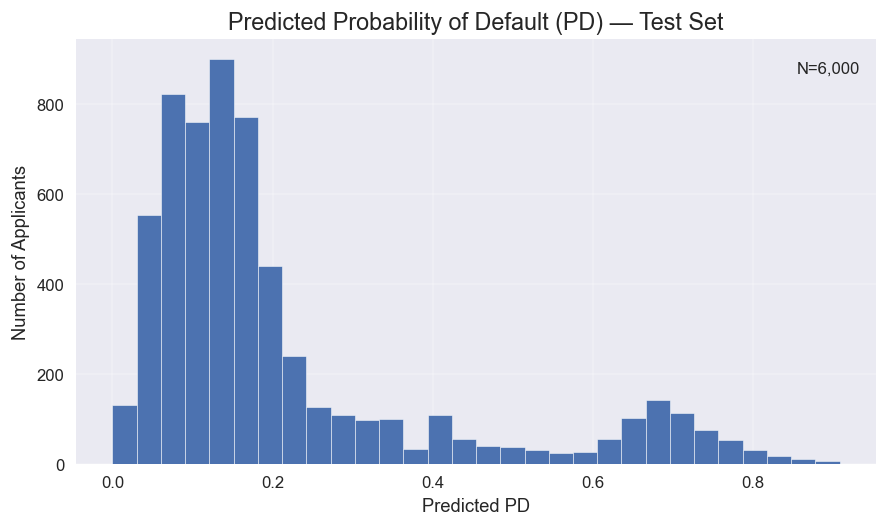

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Load data and model
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

model = joblib.load("../artifacts/models/calibrator_tuned.joblib")


# Predict PDs
pd_test = model.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.hist(pd_test, bins=30, edgecolor="white")
ax.set_title("Predicted Probability of Default (PD) — Test Set")
ax.set_xlabel("Predicted PD")
ax.set_ylabel("Number of Applicants")
ax.text(0.98, 0.95, f"N={len(pd_test):,}", transform=ax.transAxes,
        ha="right", va="top")
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/pd_distribution_test.png")
plt.show()


Visualization 2: Decision Distribution (Approve / Review / Reject)

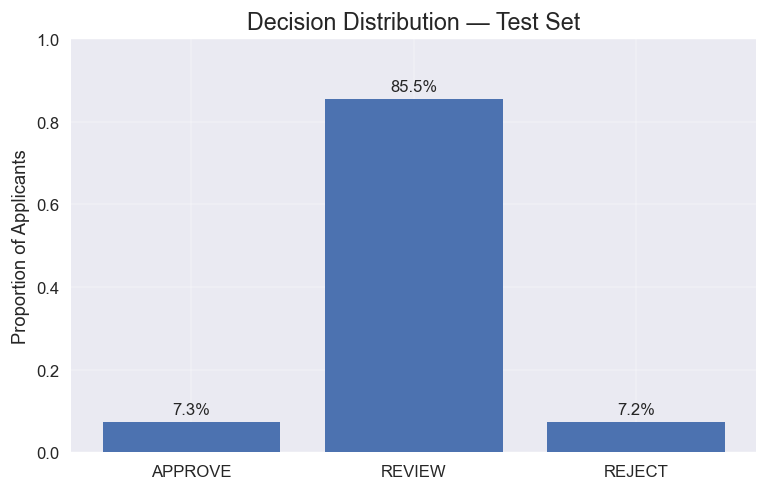

In [16]:
import numpy as np
import matplotlib.pyplot as plt

t_approve = 0.05
t_reject = 0.67

def decision(pd):
    if pd < t_approve:
        return "APPROVE"
    elif pd < t_reject:
        return "REVIEW"
    else:
        return "REJECT"

decisions = pd.Series([decision(p) for p in pd_test])
counts = decisions.value_counts(normalize=True).reindex(["APPROVE", "REVIEW", "REJECT"])

fig, ax = plt.subplots(figsize=(6.5, 4.2))
ax.bar(counts.index, counts.values)
ax.set_title("Decision Distribution — Test Set")
ax.set_ylabel("Proportion of Applicants")
ax.set_ylim(0, 1)

for i, v in enumerate(counts.values):
    ax.text(i, v + 0.02, f"{v:.1%}", ha="center")

fig.tight_layout()
fig.savefig(f"{FIG_DIR}/decision_distribution_test.png")
plt.show()


Visualization 3: Calibration Curve

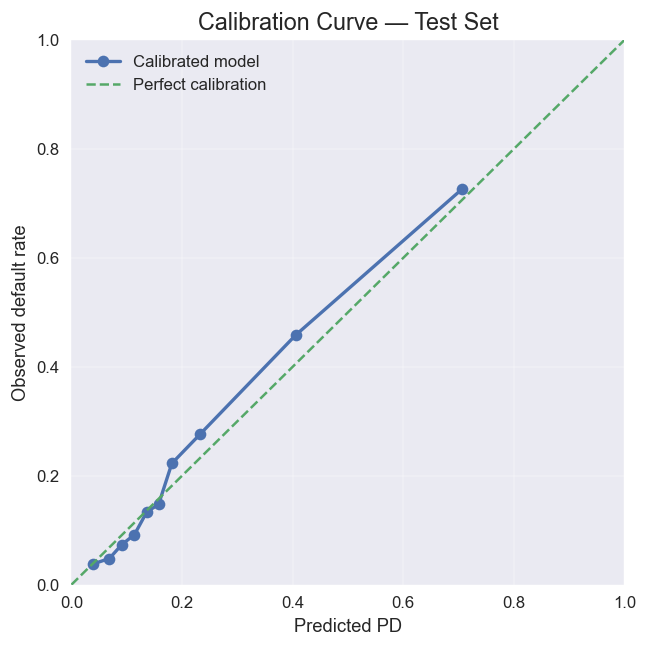

In [17]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, pd_test, n_bins=10, strategy="quantile")

fig, ax = plt.subplots(figsize=(5.5, 5.5))
ax.plot(prob_pred, prob_true, marker="o", linewidth=2, label="Calibrated model")
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.5, label="Perfect calibration")
ax.set_title("Calibration Curve — Test Set")
ax.set_xlabel("Predicted PD")
ax.set_ylabel("Observed default rate")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/calibration_curve_test.png")
plt.show()


Visualization 4: Feature Importance

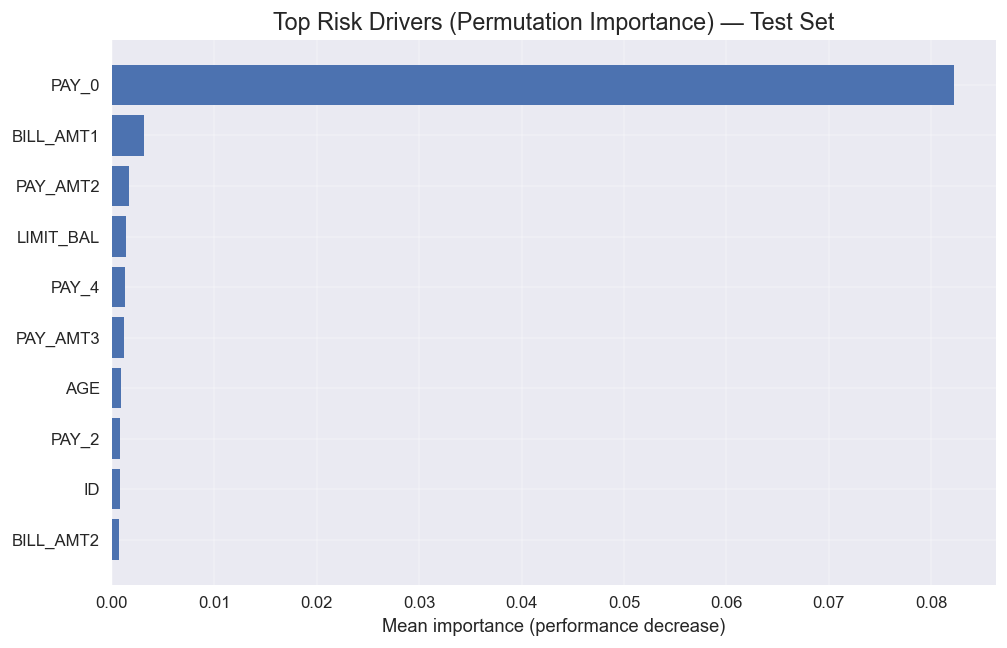

In [18]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.barh(imp["feature"][::-1], imp["importance"][::-1])
ax.set_title("Top Risk Drivers (Permutation Importance) — Test Set")
ax.set_xlabel("Mean importance (performance decrease)")
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/feature_importance_top10_test.png")
plt.show()
